# Chapter 12: Discriminant Analysis and Other Linear Classification Models

In [1]:
from rpy2 import robjects
from rpy2.robjects.packages import importr, data
import os, warnings
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder

plt.rcParams['axes.grid'] = True
plt.gray()

%matplotlib inline
pd.set_option('mode.chained_assignment',None)

warnings.filterwarnings("ignore")

<Figure size 640x480 with 0 Axes>

In [2]:
base = importr('base')
set_seed = robjects.r("set.seed")
APM = importr('AppliedPredictiveModeling')

## 1. Read Data

In [4]:
def cleanRawData(raw0):
    raw = raw0.copy()
    raw['Sponsor.Code'] = raw['Sponsor.Code'].fillna('Unk')
    raw['Sponsor.Code'] = 'Sponsor'+raw['Sponsor.Code']

    raw['Grant.Category.Code'] = raw['Grant.Category.Code'].fillna('Unk')
    raw['Grant.Category.Code'] = 'GrantCat'+raw['Grant.Category.Code']

    raw['Contract.Value.Band...see.note.A'] = raw['Contract.Value.Band...see.note.A'].fillna('Unk')
    raw['Contract.Value.Band...see.note.A'] = 'ContractValueBand'+raw['Contract.Value.Band...see.note.A']

    raw['Role.1'] = raw['Role.1'].fillna('Unk')
    return raw
    
def getVerticalData(raw):
    namesPre = []
    int1to15 = [str(x) for x in range(1,16)]
    for x in raw.columns:
        if x[x.rfind(".")+1:] in int1to15:
            if x[:x.rfind(".")] not in namesPre:
                namesPre.append(x[:x.rfind(".")])
                
    tmp = []
    for i in range(1,16):
        tmpData = pd.DataFrame()
        tmpData['Grant.Application.ID'] = raw['Grant.Application.ID']
        for x in namesPre:
            if x+'.'+str(i) in raw.columns:
                tmpData[x] = raw[x+'.'+str(i)]
        tmp.append(tmpData)
    vertical = pd.concat(tmp)
    vertical = vertical[vertical['Role'].notnull()]
    return vertical

def cleanVerticalData(v0):
    v = v0.copy()
    v.loc[v['Country.of.Birth'].notnull(),'Country.of.Birth'] = \
        v[v['Country.of.Birth'].notnull()]['Country.of.Birth'].apply(lambda x: x.replace(" ",""))
    
    v['Home.Language'] = v['Home.Language'].apply(lambda x: 'OtherLang' if x=='Other' else x)
    v['Dept.No.'] = v['Dept.No.'].apply(lambda x: 'Dept'+str(int(x)) if pd.notna(x) else 'DeptNA')
    v['Faculty.No.'] = v['Faculty.No.'].apply(lambda x: 'Faculty'+str(int(x)) if pd.notna(x) else 'FacultyNA')
    
    v['RFCD.Code'] = v['RFCD.Code'].apply(lambda x: 'RFCD'+str(int(x)) if pd.notna(x) else 'RFCDNA')
    v['RFCD.Code'] = v['RFCD.Code'].apply(lambda x: 'RFCDNA' if x in ['RFCD0','RFCD999999'] else x)
    v.loc[v['RFCD.Code'].isin(['RFCDNA']),'RFCD.Percentage'] = None
    
    v['SEO.Code'] = v['SEO.Code'].apply(lambda x: 'SEO'+str(int(x)) if pd.notna(x) else 'SEONA')
    v['SEO.Code'] = v['SEO.Code'].apply(lambda x: 'SEONA' if x in ['SEO0','SEO999999'] else x)
    v.loc[v['SEO.Code'].isin(['SEONA']),'SEO.Percentage'] = None
    
    colName = 'No..of.Years.in.Uni.at.Time.of.Grant'
    v[colName] = v[colName].map({'>=0 to 5':'Duration0to5',
                                 '>5 to 10':'Duration5to10',
                                 '>10 to 15':'Duration10to15',
                                 'more than 15':'DurationGT15',
                                 'Less than 0':'DurationLT0'},
                           na_action='ignore')
    v[colName] = v[colName].fillna('DurationUnk')
    
    return v

def noZV(w): 
    dropColumns = []
    for c in w.columns:
        if len(w[c].drop_duplicates())==1:
            dropColumns.append(c)
    return w.drop(columns = dropColumns)
    
def getSummaryData(v):
    people, totalPub, investPub, investDuration, investFaculty, investDept, investGrants, \
        investPhD, investLang, investCountry, investDOB, investCount, grantData, SEOcount, RFCDcount \
        = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),\
        pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),\
        pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    allID = v[['Grant.Application.ID']].drop_duplicates().sort_values('Grant.Application.ID')
    
    shortNames = {"EXT_CHIEF_INVESTIGATOR":"ECI", "STUD_CHIEF_INVESTIGATOR":"SCI", "CHIEF_INVESTIGATOR":"CI",\
                 "DELEGATED_RESEARCHER":"DR", "EXTERNAL_ADVISOR":"EA", "HONVISIT":"HV",\
                 "PRINCIPAL_SUPERVISOR":"PS", "STUDRES":"SR", "Unk":"UNK", "":""}
    
    # calculate the number of people per Grant application
    w = v.groupby('Grant.Application.ID').agg(numPeople = ('Grant.Application.ID','count')).reset_index()
    people = noZV(allID.merge(w, on = ['Grant.Application.ID'], how = 'left'))
    
    # calculate the number of people per role
    pt = v[['Grant.Application.ID','Role']].groupby(['Grant.Application.ID', 'Role']).\
        agg(num = ('Role','count')).reset_index().\
        pivot(index = 'Grant.Application.ID',columns = 'Role').reset_index()
    newcolname = [x[0]+shortNames[x[1]] for x in pt.columns]
    pt.columns = newcolname
    pt = pt.fillna(0)
    investCount = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the frequency of people in each age group
    x = v[['Grant.Application.ID','Role','Year.of.Birth']].\
        groupby(['Grant.Application.ID','Role','Year.of.Birth']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Year.of.Birth','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Year.of.Birth'].astype(int).astype(str)
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investDOB = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the frequency of people from each country
    x = v[['Grant.Application.ID','Role','Country.of.Birth']].\
        groupby(['Grant.Application.ID','Role','Country.of.Birth']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Country.of.Birth','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Country.of.Birth']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investCountry = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the frenquency of people for each language
    x = v[['Grant.Application.ID','Role','Home.Language']].\
        groupby(['Grant.Application.ID','Role','Home.Language']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Home.Language','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Home.Language']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investLang = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left').fillna(0))
    
    # for each role, determine who has a Ph.D
    x = v[['Grant.Application.ID','Role','With.PHD']].\
        groupby(['Grant.Application.ID','Role','With.PHD']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['With.PHD','Role'])    
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+'.PhD'
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    for x in ['EA.PhD','SCI.PhD','UNK.PhD']:
        pt[x]=0
    investPhD = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the number of successful and unsuccessful grants
    x = v[['Grant.Application.ID','Role','Number.of.Successful.Grant']].\
        groupby(['Grant.Application.ID','Role']).\
        agg(num = ('Number.of.Successful.Grant','sum')).reset_index()
    x = x.sort_values(['Role'])
    x['roleC'] = 'Success.'+x['Role'].map(shortNames,na_action = 'ignore')
    
    y = v[['Grant.Application.ID','Role','Number.of.Unsuccessful.Grant']].\
        groupby(['Grant.Application.ID','Role']).\
        agg(num = ('Number.of.Unsuccessful.Grant','sum')).reset_index()
    y = y.sort_values(['Role'])
    y['roleC'] = 'Unsuccess.'+y['Role'].map(shortNames,na_action = 'ignore')
    pt = pd.concat([x,y]).pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investGrants = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for each role/department combination
    x = v[['Grant.Application.ID','Role','Dept.No.']].\
        groupby(['Grant.Application.ID','Role','Dept.No.']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Dept.No.','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Dept.No.']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    pt = pt[[x for x in pt.columns if 'DeptNA' not in x]]
    investDept = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for each role/faculty
    x = v[['Grant.Application.ID','Role','Faculty.No.']].\
        groupby(['Grant.Application.ID','Role','Faculty.No.']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Faculty.No.','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Faculty.No.']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]    
    pt = pt[[x for x in pt.columns if 'NA' not in x]]
    investFaculty = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create dummy variables for each tenure length
    x = v[['Grant.Application.ID','No..of.Years.in.Uni.at.Time.of.Grant']].\
        groupby(['Grant.Application.ID','No..of.Years.in.Uni.at.Time.of.Grant']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    pt = x.pivot(index = 'Grant.Application.ID', columns = 'No..of.Years.in.Uni.at.Time.of.Grant', values = 'num').fillna(0)
    pt.columns.names = [None]
    investDuration = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for the number of publications per journal type. 
    # Note that we also compute the total number, 
    # which should be removed for models that cannot deal with such a linear dependency
    x = v[['Grant.Application.ID','A.','A','B','C']].\
    groupby('Grant.Application.ID').\
    agg(AstarTotal = ('A.','sum'), ATotal=('A','sum'),BTotal = ('B', 'sum'), CTotal = ('C','sum')).reset_index().fillna(0)
    x['allPub'] = x['AstarTotal']+x['ATotal']+x['BTotal']+x['CTotal']
    totalPub = x
    
    # Create variables for the number of publications per journal type per role.
    x = v[['Grant.Application.ID','Role','A.','A','B','C']].rename(columns={'A.':'Astar'}).\
        groupby(['Grant.Application.ID','Role']).\
        agg({'Astar':'sum','A':'sum', 'B':'sum','C':'sum'}).reset_index()
    pt = x.pivot(index='Grant.Application.ID', columns = 'Role', values = ['Astar','A','B','C']).fillna(0)
    newColNames = [x[0]+'.'+shortNames[x[1]] for x in pt.columns]
    pt.columns = newColNames
    pt = pt.reset_index()
    investPub = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for each RFCD code
    x = v[['Grant.Application.ID','RFCD.Code']].\
        groupby(['Grant.Application.ID','RFCD.Code']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    pt = x.pivot(index='Grant.Application.ID', columns = 'RFCD.Code',values = 'num').reset_index().drop(columns = ['RFCDNA']).fillna(0)
    pt.columns.names=[None]
    RFCDcount = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))

    # Create variables for each SEO code
    x = v[['Grant.Application.ID','SEO.Code']].\
        groupby(['Grant.Application.ID','SEO.Code']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    pt = x.pivot(index='Grant.Application.ID', columns = 'SEO.Code',values = 'num').reset_index().fillna(0).drop(columns = ['SEONA'])
    pt.columns.names=[None]
    SEOcount = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))    
    
    # Create the grantData
    x = raw[["Sponsor.Code", "Contract.Value.Band...see.note.A", "Grant.Category.Code"]]
    enc = OneHotEncoder(handle_unknown='ignore')

    startTime = raw['Start.date'].apply(lambda x : datetime.strptime(x,'%d/%m/%y'))
    startYear = startTime.apply(lambda x: x.year)

    mthabbre=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    wdayabbre = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    x['Month'] = startTime.apply(lambda x: mthabbre[x.month-1])
    x['Day'] = startTime.apply(lambda x: x.day)
    x['yDay'] = startTime.apply(lambda x: 1+(x- datetime.strptime('1/1/'+str(x.year),'%d/%m/%Y')).days)
    x['Weekday']=startTime.apply(lambda x: wdayabbre[x.dayofweek])

    y = enc.fit_transform(np.array(x[['Sponsor.Code', "Contract.Value.Band...see.note.A", "Grant.Category.Code",'Month','Weekday']]))
    y = pd.DataFrame(data = y.toarray(),columns = enc.get_feature_names_out())
    y = y.rename(columns = dict(zip(list(y.columns), [x[3:] for x in y.columns])))
    y['Day'] = x['Day']
    y['yDay'] = x['yDay']
    y['Grant.Application.ID'] = raw['Grant.Application.ID']
    y['Class'] = raw['Grant.Status'].map({0:'unsuccessful', 1:'successful'})
    y['is2008'] = startYear == 2008
    y.columns = [a.strip() for a in y.columns]
    grantData = noZV(y)
    
    # Merge all the predictors together, remove zero variance columns and merge in the outcome data
    summarized = investCount
    for x in [investDOB, investCountry, investLang, investPhD, investGrants, \
        investDept, investFaculty, investDuration, investPub, totalPub, people, RFCDcount, SEOcount, grantData]:
        summarized = summarized.merge(x, on = ['Grant.Application.ID'], how = 'left')
    
    return investCount, investDOB, investCountry, investLang, investPhD, investGrants, \
        investDept, investFaculty, investDuration, investPub, totalPub, people, RFCDcount, SEOcount, grantData, summarized

In [5]:
def checkVerticalData(v):
    vertical_filename='vertical.csv'
    vertical_path = os.path.join(unimelbdatafolder, vertical_filename)

    v0 = pd.read_csv(vertical_path)
    v0['RFCD.Code'] = v0['RFCD.Code'].fillna('RFCDNA')
    v0['SEO.Code'] = v0['SEO.Code'].fillna('SEONA')
    v0['Dept.No.'] = v0['Dept.No.'].fillna('DeptNA')
    v0['Faculty.No.'] = v0['Faculty.No.'].fillna('FacultyNA')

    v0s = v0.sort_values(['Grant.Application.ID','RFCD.Code']).reset_index(drop=True)
    vs = v.sort_values(['Grant.Application.ID','RFCD.Code']).reset_index(drop=True)
    return v0s.equals(vs)

def checkSummaryData(summary):
    s = summary[-1].copy()
    s.columns = [x.lower() for x in s.columns]
    s =s.drop(columns = ['grant.application.id'])
    if 'yday' in s.columns:
        s = s.drop(columns=['yday'])

    summary_filename='summarized.csv'
    summary_path = os.path.join(unimelbdatafolder, summary_filename)
    s0 = pd.read_csv(summary_path)
    s0.columns = [x.lower() for x in s0.columns]

    cm = s[list(s0.columns)]==(s0)
    diffcol = []
    for x in s.columns:
        if (len(cm[x].value_counts())!=1):
            diffcol.append(x)

    # Check columns with PhD information: differ by NaN values
    p = summary[4].copy()
    p.columns = [x.lower() for x in p.columns]

    PHD_filename='investPhD.csv'
    PHD_path = os.path.join(unimelbdatafolder, PHD_filename)

    p0 = pd.read_csv(PHD_path)
    p0.columns = [x.lower() for x in p0.columns]
    p0 = p0[list(p.columns)]

    p = p.fillna('Missing')
    p0 = p0.fillna('Missing')

    # Check country columns: fill nan by 0 in getSummaryData
    c = summary[2].copy()
    c.columns = [x.lower() for x in c.columns]
    for x in c.columns:
        c[x]=c[x].fillna(0).astype('int64')

    Country_filename='investCountry.csv'
    Country_path = os.path.join(unimelbdatafolder, Country_filename)

    c0 = pd.read_csv(Country_path)
    c0.columns = [x.lower() for x in c0.columns]
    c0 = c0[list(c.columns)]

    # Check DOB columns: fill nan by 0 in getSummaryData
    b = summary[1].copy()
    b.columns = [x.lower() for x in b.columns]
    for x in b.columns:
        b[x]=b[x].fillna(0).astype('int64')

    DOB_filename='investDOB.csv'
    DOB_path = os.path.join(unimelbdatafolder, DOB_filename)

    b0 = pd.read_csv(DOB_path)
    b0.columns = [x.lower() for x in b0.columns]
    b0 = b0[list(b.columns)]

    return "Columns in Country and Date.of.Birth needs to fill null values by 0", {'PhD':p0.equals(p), 'Country': c0.equals(c), 'Date.of.Birth':b0.equals(b)}, \
    [x for x in list(c.columns)+list(b.columns) if x.lower()!='grant.application.id']

In [6]:
def getTrainTestData(s):
    summarized = s.copy()
    col1 = [x for x in summarized.columns if x.lower() =='is2008'][0]
    col2 = [x for x in summarized.columns if x.lower() =='grant.application.id'][0]
    
    training = summarized[~summarized[col1]] # data not in 2008
    year2008= summarized[summarized[col1]] # data in 2008

    np.random.seed(552)
    inTrain = np.random.choice(year2008.index, size = 1557, replace = False) # add 1557 records into training

    training2 = year2008[year2008.index.isin(inTrain)]
    testing = year2008[~year2008.index.isin(inTrain)] # 518 records of year 2008 as testing
    training = pd.concat([training, training2])

    training = training.drop(columns = [col1,col2])
    testing = testing.drop(columns = [col1,col2])

    training = noZV(training)
    testing = testing[list(training.columns)]
    year2008 = year2008[list(training.columns)]
    return training, testing, year2008

In [7]:
def removeHighCorrColumns(XTrain, threshold = 0.99):
    corr_df = XTrain.corr().fillna(0)
    for i in range(len(corr_df)):
        corr_df.iloc[i,i] = 0
    abs_corr = np.abs(np.array(corr_df))
    columnnames = list(corr_df.columns)

    while abs_corr.max() > threshold:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape)
        #print(i,j, abs_corr.max())
        if abs_corr[i,].mean()> abs_corr[j,].mean():
            k = i
        else:
            k = j
        columnnames.pop(k)
        abs_corr = np.delete(abs_corr, k, axis = 0)
        abs_corr = np.delete(abs_corr, k, axis = 1)
    return columnnames

def nearZeroVar(X, freqCut):
    columnnames = list(X.columns)
    percentUnique, freqRatio, zeroVar, nzv = [], [], [], []
    for c in columnnames:
        w = X[c]
        valcnt = w.value_counts().values
        percentUnique.append(100* len(valcnt)/valcnt.sum())
        zeroVar.append(True if len(valcnt)==1 else False)
        if len(valcnt)==1: 
            freqRatio.append(0)
        else:
            freqRatio.append(valcnt[0]/valcnt[1])
        nzv.append(freqRatio[-1]==0 or freqRatio[-1]>freqCut)
    df = pd.DataFrame({'col':columnnames, 'freqRatio':freqRatio, 'zeroVar':zeroVar,'nzv':nzv}).set_index('col')
    df.index.name = None
    return df

def getFullSetReducedSet(training):
    fullSet = [x for x in training.columns if x.lower()!='class']
    XTrain = training[fullSet]
    col1 = removeHighCorrColumns(XTrain)
    fullSet = col1

    isNZV = nearZeroVar(training[fullSet], int(len(training)/5))
    fullSet = list(isNZV[~isNZV['nzv']].index)

    reducedSet = list(isNZV[(~isNZV['nzv']) & (isNZV['freqRatio']<int(len(training)/50))].index)
    reducedSet = [x for x in reducedSet if x.lower() not in ['allpub','numpeople','mar','sun']]
    return fullSet, reducedSet

In [4]:
# year 2008 has 2075 records, pre 2008 has 6633 records
# Training : pre2008 data + 1557 records in year 2008
# Testing: 518 records in year 2008
training = pd.read_csv('./grantdata_training.csv')
testing = pd.read_csv('./grantdata_testing.csv')
year2008Data = pd.read_csv('./grantdata_year2008Data.csv')

In [7]:
print(training.info())
print(testing.info())
print(year2008Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 118.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 7.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 30.0+ MB
None


In [30]:
fullSet = pd.read_csv("./fullset.csv")['colName'].to_list()
reducedSet = pd.read_csv("./reducedset.csv")['colName'].to_list()

len(fullSet), len(reducedSet) #1069,  255 changed Day to yDay

(1069, 255)

In [10]:
trainData = training[~training.index.isin(year2008Data.index)]
validData = training[training.index.isin(year2008Data.index)]
fillNAcols = ['CI.PhD','DR.PhD','ECI.PhD','HV.PhD','PS.PhD','SR.PhD','EA.PhD','SCI.PhD','UNK.PhD']
trainData[fillNAcols] = trainData[fillNAcols].fillna(0)
validData[fillNAcols] = validData[fillNAcols].fillna(0)

trainData['yDay2'] = trainData['yDay']**2
validData['yDay2'] = validData['yDay']**2

In [11]:
trainX0 = trainData.drop(columns = ['Class'])
trainy = trainData['Class'].apply(lambda x : 1 if x =='successful' else 0)
validX0 = validData.drop(columns = ['Class'])
validy = validData['Class'].apply(lambda x : 1 if x =='successful' else 0)

In [12]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, get_scorer_names
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score

In [13]:
def modelPerf(model, X, y):
    nl = '\n'
    y_true = y
    y_pred = model.predict(X)
    print(f"Terms: 1 for positive case, and 0 for negative case. \
    {nl}  P - the number of real positive cases in the data \
    {nl}  TP - a test result that correctly indicates the presence of a condition \
    {nl}  FP - a test result which wrongly indicates that a condition is present \
    {nl}  N - the number of real negative cases in the data \
    {nl}  TN - a test result that correctly indicates the absence of a condition \
    {nl}  FN - a test result which wrongly indicates that a condition is absent \
    {nl}  Precision, positive predicitive value(PPV) - TP/(TP+FP) \
    {nl}  Reacll, sensitivity, true positive rate(TPR) - TP/P \
    {nl}  Specificity, selectivity, true negative rate(TNR) - TN/N \
    {nl}  Accuracy - (TP+TN)/(P+N)")
    print(f"The confusion matrix \
    {nl}  TN | FP \
    {nl}  FN | TP")
    print(f"Report of {model.__class__.__name__}:")
    print(classification_report(y_true, y_pred, digits = 7))
    
    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=model.classes_)
    cmdisp.plot(ax = ax1)
    
    y_score = model.predict_proba(X)[:,1]
    roc_area = roc_auc_score(y_true, y_score)
    ax2 = f.add_subplot(122)
    roc_disp = RocCurveDisplay.from_estimator(model, X, y, ax = ax2)
    print(f"The area under the ROC curve is {roc_area}")

In [14]:
cv = ShuffleSplit(n_splits = 4, test_size = 0.25, random_state=3)

## 2. Logistic Regression
{0:'unsuccessful', 1:'successful'}

In [19]:
lr = linear_model.LogisticRegression()
logReg_param = [{'solver': ['lbfgs','newton-cg','newton-cholesky','sag'],
                 'penalty':['l2',None]},
                {'solver': ['liblinear'],
                 'penalty':['l1','l2']},
                {'solver': ['saga'],
                 'penalty':['l1','l2',None]}]

### 2.1 One feature

In [22]:
onefeatName = ['yDay']
trainX = trainX0[onefeatName]
validX = validX0[onefeatName]

In [23]:
modelFit= linear_model.LogisticRegression()
modelFit.fit(trainX, trainy)

LogisticRegression()

In [24]:
lin_a = modelFit.coef_[0][0]
lin_b = modelFit.intercept_[0]

lin_a, lin_b

(-0.004238095577989463, 0.9193353121819308)

In [25]:
quad = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
trainX_quad= quad.fit_transform(trainX)

daySquareGS= GridSearchCV(lr, logReg_param, cv = cv, scoring = "roc_auc", n_jobs = -1)
daySquareGS.fit(trainX_quad, trainy)
daySquareModel = daySquareGS.best_estimator_

/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: 

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.5891643 0.7900000 0.6749592      3400
           1  0.6557377 0.4206619 0.5125306      3233

    accuracy                      0.6099804      6633
   m

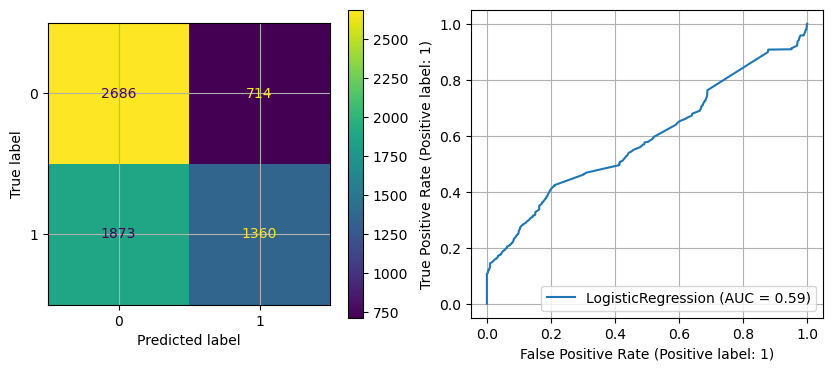

In [26]:
modelPerf(modelFit,trainX, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.5712399 0.8902941 0.6959421      3400
           1  0.7203898 0.2972471 0.4208452      3233

    accuracy                      0.6012362      6633
   m

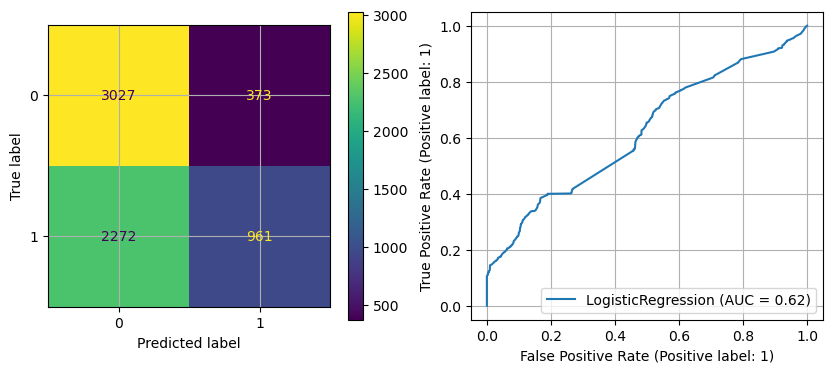

In [27]:
modelPerf(daySquareModel,trainX_quad,trainy)

In [28]:
df1=pd.DataFrame({'yDay':trainX['yDay'],'output':trainy})
df1['dayBin'] = pd.cut(df1.yDay, list(range(1,366,5)),right=False)
df2 = df1.groupby('dayBin').agg({'output':'mean'}).reset_index()
df2['leftPt'] = df2['dayBin'].apply(lambda x: x.left)

sqc1, sqc2 = daySquareModel.coef_[0]
sq_b = daySquareModel.intercept_[0]

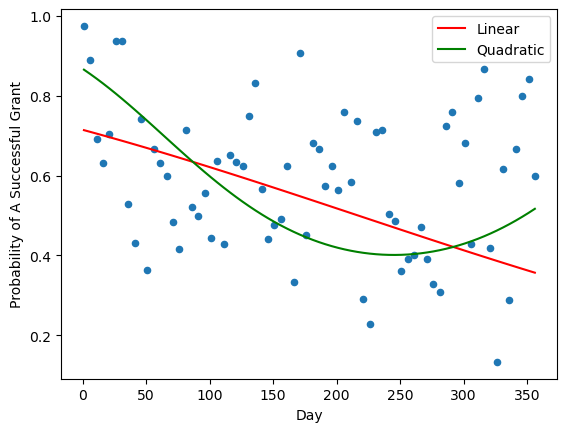

In [29]:
dx = np.linspace(1,356,72)
dy = 1/(1+np.exp(-(lin_b+lin_a*dx)))
dz = 1/(1+np.exp(-(sq_b +sqc1*dx +sqc2*dx*dx)))

ax1 = df2.plot.scatter(x = 'leftPt', y = 'output',grid = False, xlabel = 'Day', ylabel = 'Probability of A Successful Grant')
ax1.plot(dx,dy, c='red', label = 'Linear')
ax1.plot(dx,dz, c='green', label = 'Quadratic')
_ = ax1.legend()

### 2.2 Reduced set and full set

In [32]:
trainX = trainX0[reducedSet+['yDay2']]
validX = validX0[reducedSet+['yDay2']]

In [35]:
lrReducedGS = GridSearchCV(lr, logReg_param, cv=cv, scoring = 'roc_auc', n_jobs = -1)
lrReducedGS.fit(trainX, trainy)

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

GridSearchCV(cv=ShuffleSplit(n_splits=4, random_state=3, test_size=0.25, train_size=None),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'penalty': ['l2', None],
                          'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                     'sag']},
                         {'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'penalty': ['l1', 'l2', None], 'solver': ['saga']}],
             scoring='roc_auc')

In [36]:
lr_reduced = lrReducedGS.best_estimator_

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.9068361 0.8694896 0.8877702      3448
           1  0.8398006 0.8845144 0.8615778      2667

    accuracy                      0.8760425      6115
   m

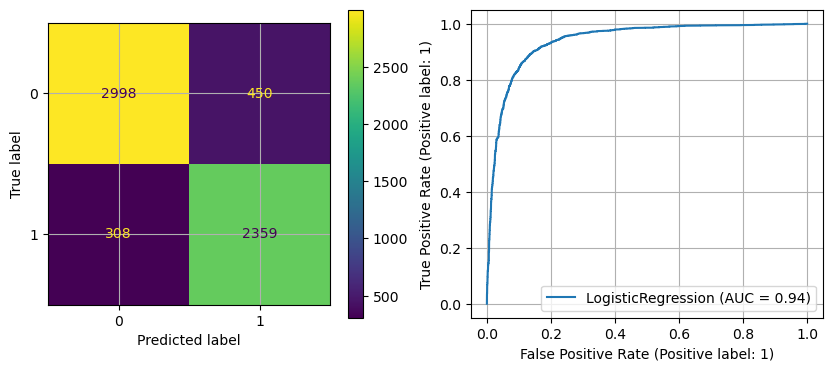

In [37]:
modelPerf(lr_reduced, trainX, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.6294174 0.6995754 0.6626445       942
           1  0.7247082 0.6575463 0.6894956      1133

    accuracy                      0.6766265      2075
   m

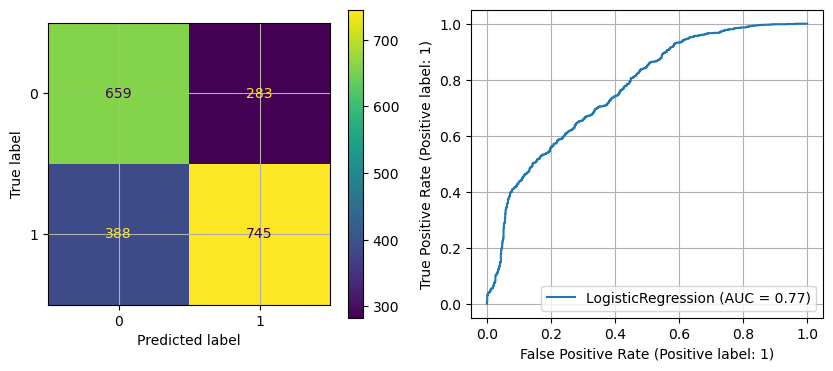

In [38]:
modelPerf(lr_reduced, validX, validy)

In [39]:
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]

In [40]:
lrFullGS = GridSearchCV(lr, logReg_param, cv=cv, scoring = 'roc_auc', n_jobs = -1)
lrFullGS.fit(trainX, trainy)
lr_full = lrFullGS.best_estimator_

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.9224319 0.8932715 0.9076175      3448
           1  0.8674352 0.9028871 0.8848062      2667

    accuracy                      0.8974652      6115
   m

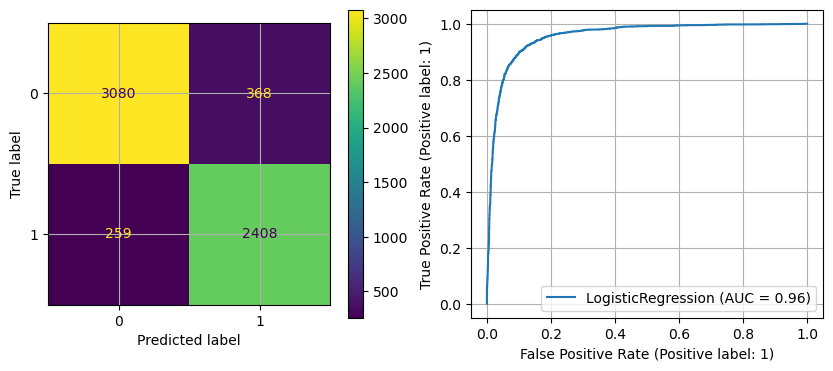

In [41]:
modelPerf(lr_full, trainX, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.6361032 0.7070064 0.6696833       942
           1  0.7315175 0.6637246 0.6959741      1133

    accuracy                      0.6833735      2075
   m

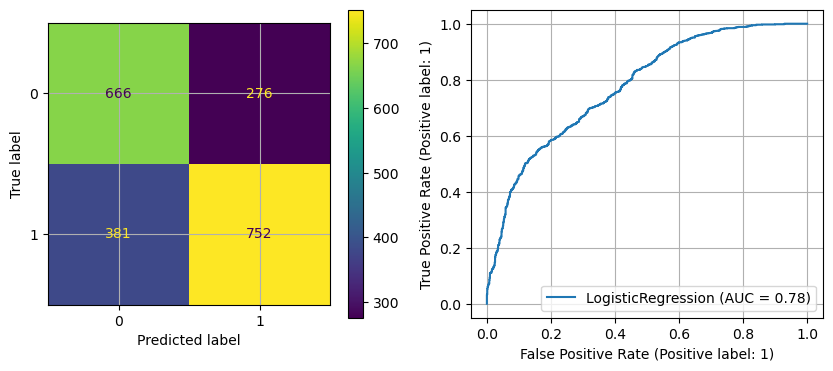

In [42]:
modelPerf(lr_full, validX, validy)

## 3. Linear Discriminant Analysis

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [44]:
trainX = trainX0[reducedSet+['yDay2']]
validX = validX0[reducedSet+['yDay2']]

In [45]:
sc = StandardScaler()
trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [46]:
lda = LinearDiscriminantAnalysis()
lda_param = {'solver': ['svd','lsqr','eigen']}

In [47]:
ldaGS = GridSearchCV(lda, lda_param, cv = cv, scoring = 'roc_auc', n_jobs = -1)
ldaGS.fit(trainX_scaled, trainy)
ldaModel = ldaGS.best_estimator_

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0  0.6313088 0.7834395 0.6991947       942
           1  0.7748344 0.6195940 0.6885728      1133

    accuracy                      0.6939759      2

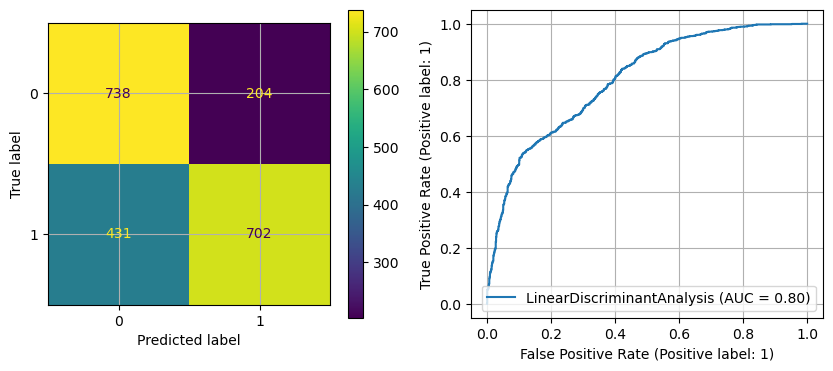

In [48]:
modelPerf(ldaModel, validX_scaled, validy)

Text(0.5, 1.0, '')

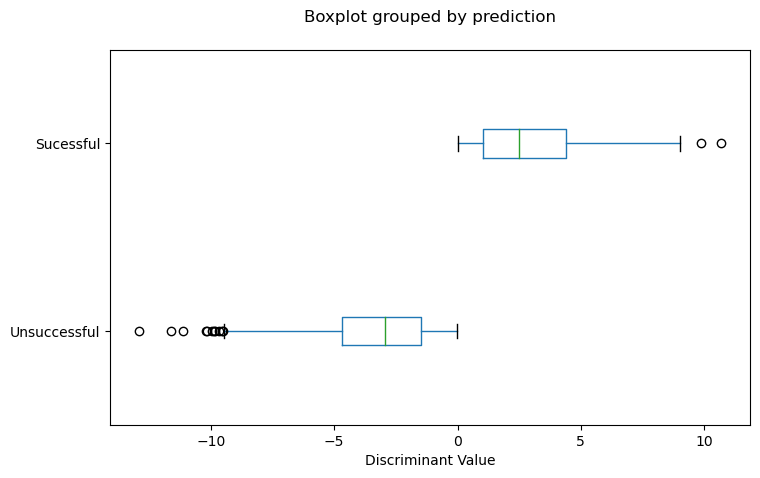

In [49]:
dfvalid = pd.DataFrame({'discriminant_value': ldaModel.decision_function(validX_scaled), 'prediction': ldaModel.predict(validX_scaled)})
fig, ax = plt.subplots(figsize = (8,5))
bplot = dfvalid.boxplot(by = 'prediction', ax = ax, vert=False, grid = False)
bplot.set_ylabel("")
bplot.set_yticks([1,2],['Unsuccessful', 'Sucessful'])
bplot.set_xlabel("Discriminant Value")
bplot.set_title("")

## 4. Partial Least Square

In [50]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

class PLSPreProc(PLSRegression):
    ''' Wrapper to allow PLSRegression to be used in the Pipeline Module '''
    def __init__(self, n_components=4, scale=False):
        super().__init__(n_components=n_components, scale=scale)

    def fit(self, X, y):
        return super().fit(X, y)

    def transform(self, X):
        return super().predict(X)

    def fit_transform(self, X, y):
        return super().fit(X,y).predict(X)

scaler = StandardScaler()
pls4 = PLSPreProc(4,False)
gnb = GaussianNB()

PLSNB = Pipeline([('scaler', StandardScaler()),('pls', pls4),('gnb',gnb)])

In [51]:
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]

In [52]:
PLSNB.fit(trainX, trainy)

Pipeline(steps=[('scaler', StandardScaler()), ('pls', PLSPreProc()),
                ('gnb', GaussianNB())])

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of Pipeline:
              precision    recall  f1-score   support

           0  0.9038288 0.8694896 0.8863267      3448
           1  0.8391708 0.8803900 0.8592864      2667

    accuracy                      0.8742437      6115
   macro avg  

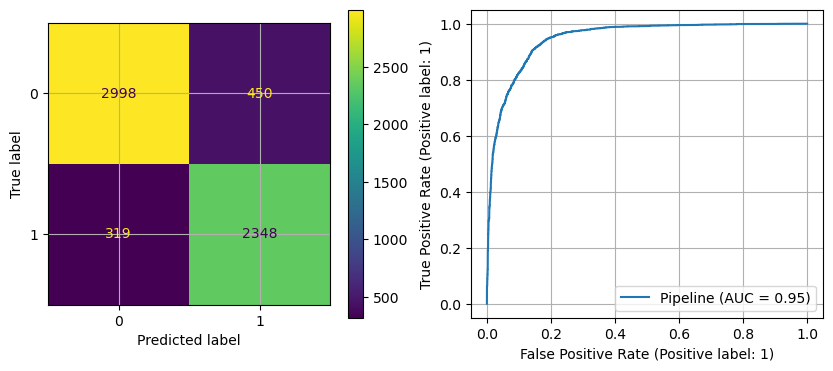

In [53]:
modelPerf(PLSNB,trainX,trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of Pipeline:
              precision    recall  f1-score   support

           0  0.6277014 0.6783439 0.6520408       942
           1  0.7133396 0.6654898 0.6885845      1133

    accuracy                      0.6713253      2075
   macro avg  

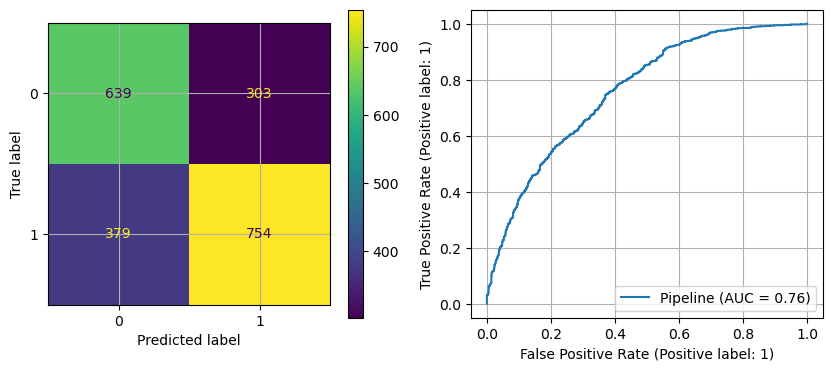

In [54]:
modelPerf(PLSNB, validX, validy)

Text(0.5, 1.0, '')

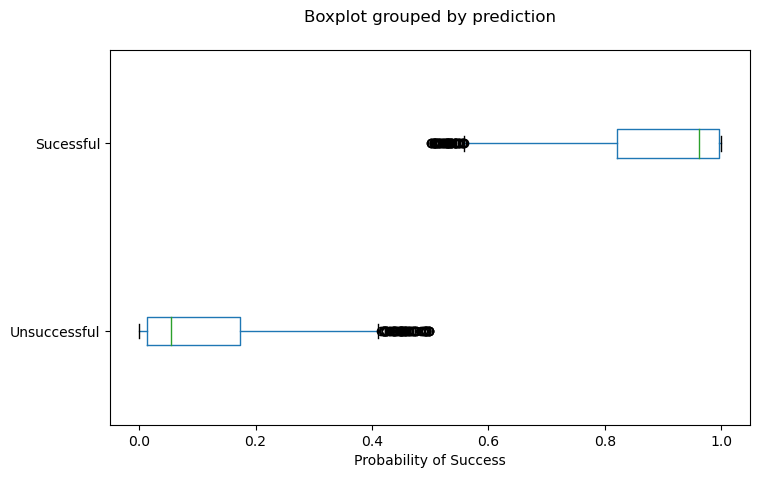

In [55]:
dfvalid = pd.DataFrame({'probability of success': PLSNB.predict_proba(validX)[:,1], 'prediction': PLSNB.predict(validX)})

fig, ax = plt.subplots(figsize = (8,5))
bplot = dfvalid.boxplot(by = 'prediction', ax = ax, vert=False, grid = False)
bplot.set_ylabel("")
bplot.set_yticks([1,2],['Unsuccessful', 'Sucessful'])
bplot.set_xlabel("Probability of Success")
bplot.set_title("")

## 5. Penalized Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

warnings.filterwarnings("ignore", message = "The max_iter was reached*")

In [ ]:
sc = StandardScaler()
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]
trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [ ]:
def hyperopt_train_test(params):
    lasso = LogisticRegression(**params, penalty='l1', solver = 'liblinear')
    return cross_val_score(lasso, trainX_scaled, trainy, cv=4, scoring ='roc_auc', n_jobs = -1).mean()

space4lasso = {
    'C': hp.loguniform('C',-10,4)
}

def f(params):
    auc = hyperopt_train_test(params)
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()
best_param_lasso = fmin(f, space4lasso, algo=tpe.suggest, max_evals=50, trials=trials)
print('best:', best_param_lasso)

In [ ]:
lassoModel = LogisticRegression(solver = 'liblinear',penalty='l1',**best_param_lasso)
lassoModel.fit(trainX_scaled,trainy)

In [ ]:
modelPerf(lassoModel, trainX_scaled, trainy)

In [ ]:
modelPerf(lassoModel, validX_scaled, validy)

In [ ]:
nonzeroCoefIdx = np.nonzero(lassoModel.coef_)[1]
for x in nonzeroCoefIdx: 
    print(f"{(fullSet+['yDay2'])[x]:<25}: {lassoModel.coef_[0,x]}")

In [ ]:
def hyperopt_train_test(params):
    enet = LogisticRegression(**params, max_iter=1000, penalty='elasticnet',solver='saga')
    return cross_val_score(enet, trainX_scaled, trainy, cv=4, scoring ='roc_auc').mean()

space4enet = {
    #'solver': hp.choice('solver',['saga']),
    #'penalty': hp.choice('penalty',['elasticnet']),
    #'max_iter': hp.choice('max_iter',[1000]),
    'l1_ratio': hp.uniform('l1_ratio',0,1),
    'C': hp.loguniform('C',-10,4)
}

def f(params):
    auc = hyperopt_train_test(params)
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4enet, algo=tpe.suggest, max_evals=50, trials=trials)
print('best:', best)

In [ ]:
bestParams = best
enetModel = LogisticRegression(**bestParams,max_iter=1000, penalty='elasticnet',solver='saga')
enetModel.fit(trainX_scaled, trainy)

In [ ]:
modelPerf(enetModel, trainX_scaled, trainy)

In [ ]:
modelPerf(enetModel, validX_scaled, validy)

In [ ]:
nonzeroCoefIdx = np.nonzero(enetModel.coef_)[1]
for x in nonzeroCoefIdx: 
    print(f"{(fullSet+['yDay2'])[x]:<25}: {enetModel.coef_[0,x]}")

## 6. Nearest Shrunken Centroids

In [ ]:
from sklearn.neighbors import NearestCentroid

In [ ]:
sc = StandardScaler()
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]
trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [ ]:
from sklearn.utils.extmath import softmax
from sklearn.metrics.pairwise import pairwise_distances
class NSC(NearestCentroid):
    ''' Wrapper to allow Nearest Centroid to have predict_proba and decision_function '''
    def __init__(self, metric ='euclidean', shrink_threshold=None):
        super().__init__(metric=metric,shrink_threshold=shrink_threshold)

    def predict_proba(self, X):
        distances = pairwise_distances(X, self.centroids_, metric=self.metric)
        probs = softmax(-distances)
        return probs
    
    def decision_function(self, X):
        distances = pairwise_distances(X, self.centroids_, metric=self.metric)
        probs = softmax(-distances)
        return probs[:,1]

In [ ]:
nsc= NSC()
nsc_param = {'shrink_threshold': list(np.linspace(0,1,100))[1:]}

In [ ]:
nscGS = GridSearchCV(nsc, nsc_param, cv=cv, scoring = 'accuracy', n_jobs = -1)
nscGS.fit(trainX_scaled, trainy)
nscModel = nscGS.best_estimator_

In [ ]:
nscModel

In [ ]:
modelPerf(nscModel,trainX_scaled,trainy)

In [ ]:
modelPerf(nscModel,validX_scaled,validy)